 ## MNIST Neural Network from Scratch (with Numpy)
 Based on tutorial from Samson Zhang: https://www.youtube.com/watch?v=w8yWXqWQYmU
 Data taken from here: https://pjreddie.com/projects/mnist-in-csv/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# read in data from csv (using pandas with pyarrow engine - faster)
colnames = ["label"] + [f"pixel_{i}" for i in range(784)]
train_df = pd.read_csv(
    "https://pjreddie.com/media/files/mnist_train.csv", engine="pyarrow", names=colnames
)

In [3]:
test_df = pd.read_csv(
    "https://pjreddie.com/media/files/mnist_test.csv", engine="pyarrow", names=colnames
)

In [4]:
train_df.head()

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


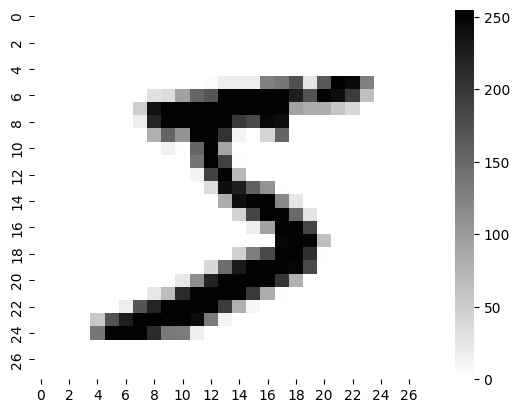

In [5]:
# plot an example number
_ = sns.heatmap(train_df.iloc[0, 1:].values.reshape(28, 28), cmap="gray_r")

In [6]:
# Functions for NN
def init_params():
    """Initialize parameters for NN
    
    Parameters
    ----------
    None
    
    Returns
    -------
    W1, b1, W2, b2: numpy arrays
        Weight and bias matrices for each layer
    
    """
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(x):
    """ReLU activation function
    
    Parameters
    ----------
    x: numpy array
        Input to activation function
    
    Returns
    -------
    numpy array
        Output of activation function
    
    """
    return np.maximum(x, 0)

def softmax(x):
    """Softmax activation function
    
    Parameters
    ----------
    x: numpy array
        Input to activation function
    
    Returns
    -------
    numpy array
        Output of activation function
    
    """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(W1, b1, W2, b2, x):
    """Forward propagation through NN
    
    Parameters
    ----------
    W1, b1, W2, b2: numpy arrays
        Weight and bias matrices for each layer
    x: numpy array
        Input to NN
    
    Returns
    -------
    z1, a1, z2, a2: numpy arrays
        Output of each layer of NN
    
    """
    # Perform the matrix multiplication between weights W1 and input x, and add bias b1
    z1 = W1.dot(x) + b1

    # Apply the ReLU activation function to the result of the first layer
    a1 = ReLU(z1)

    # Perform the matrix multiplication between weights W2 and the output of the first layer a1, and add bias b2
    z2 = W2.dot(a1) + b2

    # Apply the softmax activation function to the result of the second layer
    a2 = softmax(z2)

    # Return the intermediate outputs of each layer for later use
    return z1, a1, z2, a2

def ReLU_derivative(x):
    """Derivative of ReLU activation function
    
    Parameters
    ----------
    x: numpy array
        Input to activation function
    
    Returns
    -------
    numpy array
        Output of activation function
    """
    return np.where(x > 0, 1, 0)

def one_hot_encode(y):
    """One-hot encode labels
    
    Parameters
    ----------
    y: numpy array
        Labels
    
    Returns
    -------
    numpy array
        One-hot encoded labels
    
    """
    one_hot = np.zeros((y.size, y.max() + 1))
    one_hot[np.arange(y.size), y] = 1
    return one_hot.T

def backward_prop(z1, a1, z2, a2, w1, w2, x, y):
    """Backward propagation through NN
    
    Parameters
    ----------
    z1, a1, z2, a2: numpy arrays
        Output of each layer of NN
    w1, w2: numpy arrays
        Weight matrices for each layer
    x: numpy array
        Input to NN
    y: numpy array
        Labels
    
    Returns
    -------
    dw1, db1, dw2, db2: numpy arrays
        Gradients of each layer of NN
    
    """
    m = y.size
    
    # Convert labels to one-hot encoding
    one_hot_y = one_hot_encode(y)

    # Compute the error in the output layer
    dZ2 = a2 - one_hot_y

    # Compute the gradient of the second layer's weights
    dW2 = 1 / m * dZ2.dot(a1.T)

    # Compute the gradient of the second layer's biases
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

    # Compute the error in the first layer
    dZ1 = w2.T.dot(dZ2) * ReLU_derivative(z1)

    # Compute the gradient of the first layer's weights
    dW1 = 1 / m * dZ1.dot(x.T)

    # Compute the gradient of the first layer's biases
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

    # Return the gradients for each layer
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    """Update parameters of NN
    
    Parameters
    ----------
    W1, b1, W2, b2: numpy arrays
        Weight and bias matrices for each layer
    dW1, db1, dW2, db2: numpy arrays
        Gradients of each layer of NN
    learning_rate: float
        Learning rate for gradient descent
        
    Returns
    -------
    W1, b1, W2, b2: numpy arrays
        Updated weight and bias matrices for each layer
    
    """
    
    # Update the first layer's weights
    W1 = W1 - learning_rate * dW1

    # Update the first layer's biases
    b1 = b1 - learning_rate * db1

    # Update the second layer's weights
    W2 = W2 - learning_rate * dW2

    # Update the second layer's biases
    b2 = b2 - learning_rate * db2

    # Return the updated parameters
    return W1, b1, W2, b2

In [7]:
def get_predictions(A2):
    return np.argmax(A2, 0)
    
def get_accuracy(predictions, y):
    return np.sum(predictions == y) / y.size

def train_nn(x, y, iterations, learning_rate):
    w1, b1, w2, b2 = init_params()
    info_df = pd.DataFrame(columns=["Iteration", "Accuracy"])
    for i in range(iterations):
        z1, a1, z2, a2 = forward_prop(w1, b1, w2, b2, x)
        dW1, db1, dW2, db2 = backward_prop(z1, a1, z2, a2, w1, w2, x, y)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 100 == 0:
            predictions = get_predictions(a2)
            accuracy = get_accuracy(predictions, y)
            info_df = pd.concat([info_df, pd.DataFrame([[i, accuracy]], columns=["Iteration", "Accuracy"])])
    return w1, b1, w2, b2, info_df

In [8]:
# Train NN
x_train = train_df.iloc[:, 1:].values.T / 255
y_train = train_df.iloc[:, 0].values.reshape(-1, 1).T
w1, b1, w2, b2, info_df = train_nn(x_train, y_train, 1000, 0.1)

In [9]:
info_df

,Iteration,Accuracy
0,0,0.088583
0,100,0.676033
0,200,0.774667
0,300,0.811783
0,400,0.834250
0,500,0.848500
0,600,0.858433
0,700,0.866267
0,800,0.871650
0,900,0.876083


In [10]:
def make_predictions(x, w1, b1, w2, b2):
    _, _, _, a2 = forward_prop(w1, b1, w2, b2, x)
    return get_predictions(a2)

def test_prediction(index):
    x = test_df.iloc[index, 1:].values.reshape(784, 1) / 255
    prediction = make_predictions(x, w1, b1, w2, b2)
    print(f"Prediction: {prediction}")
    print(f"Actual: {test_df.iloc[index, 0]}")
    _ = sns.heatmap(x.reshape(28, 28), cmap="gray_r")

Prediction: [4]
Actual: 4


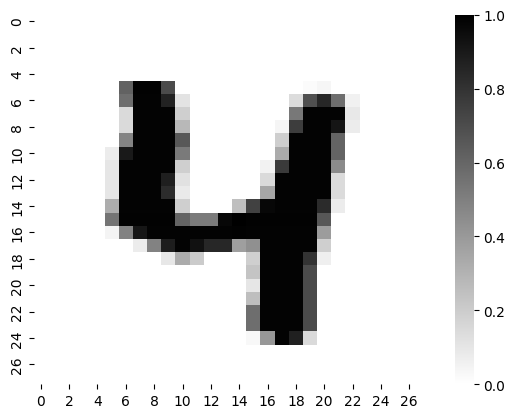

Prediction: [9]
Actual: 9


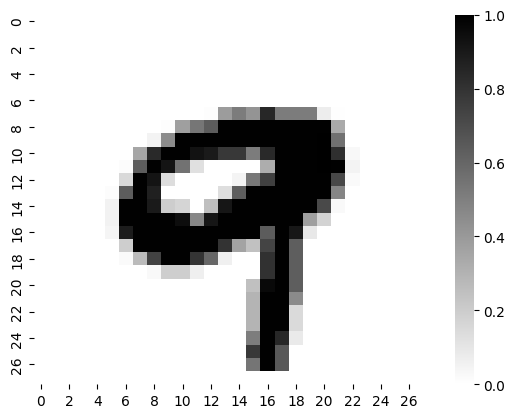

Prediction: [6]
Actual: 6


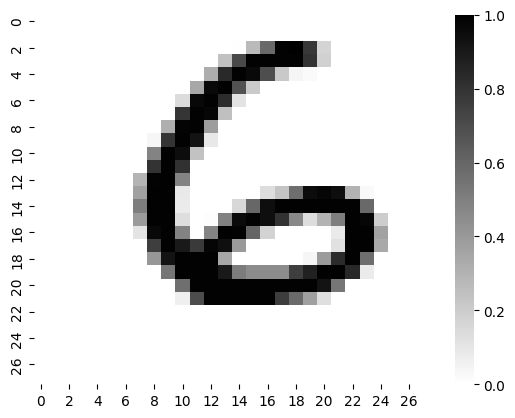

Prediction: [0]
Actual: 0


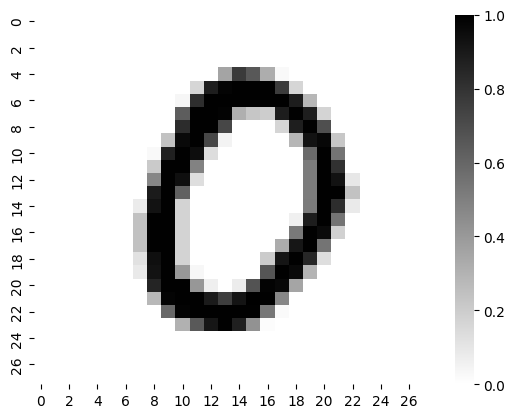

In [11]:
np.random.seed(42)
for index in np.random.randint(0, 4000, 4):
    test_prediction(index)
    _ = plt.show()

In [12]:
x_test = test_df.iloc[:, 1:].values.T / 255
y_test = test_df.iloc[:, 0].values.reshape(-1, 1).T
predictions = make_predictions(x_test, w1, b1, w2, b2)
accuracy = get_accuracy(predictions, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8789
